<a href="https://colab.research.google.com/github/yes-G/FussballPrognose/blob/analysis/LeagueAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

The idea is find a football team which has managed to repeat its performance across two consequtive seasons in the past 10 years. Not based on the where they finish in their league, but to see if the points they've scored have been consistant.

In [ ]:
!pip install datapackage

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

# How long ago should i look? 
I will examine the data from the past 10 years, for the Spanish 1st Division Football league - the La Liga. Taken literally, one would imagine the creators of the said league to be very arrogant, because its literally means *The League.* And that implies that there can be no other ;)

Is 10 years too much? too less? 

#Datahub

This time instead of scrubbing data from a website, i will use the data from the good folks at datahub.io who make available a large number of datasets. 


In [ ]:
import datapackage

data_url = 'https://datahub.io/sports-data/spanish-la-liga/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources

The data for all the seasons is colated into one dataframe.

In [ ]:
sources = []
df = None
for resource in resources:
  if resource.tabular:
    #print(resource.name, resource.descriptor['dpp:streamedFrom'])    
    if resource.descriptor['dpp:streamedFrom'] not in sources:
      sources.append(resource.descriptor['dpp:streamedFrom'])
      data = pd.read_csv(resource.descriptor['path'])
      data['Season']=resource.name
      if df is None:
        df = data.copy()
      else:
        df = pd.concat([df, data])
#print(sources)
#The season name is derived from the name of the csv file, but that is not very 
#"user" friendly - looks like season-0910_csv, hence a little clean up is done
#with the code below.
df.Season = df.Season.apply(lambda x: '20'+str.join('-20', #Step2: Add the 2000's qualifier and a - between the two years
                                      re.findall('..',  #Step 1: split the string with every 2 digits.
                                     re.sub('[a-z]+|[-_]', '',x))#Step 0. ignore season, csv and the - and _ 
                            ))

#How many teams appear in the dataset and in how many seasons did a team appear in?

From the seasons from 2008-09 upto 2018-19, a total of 35 teams have made an appearance in the *La Liga*. Only 20 teams participate in a season. 

In [ ]:
Teams = df.HomeTeam.unique().tolist()
Teams.sort()
dfSeason = pd.DataFrame(df.groupby(by='HomeTeam')['Season'].nunique()).reset_index()


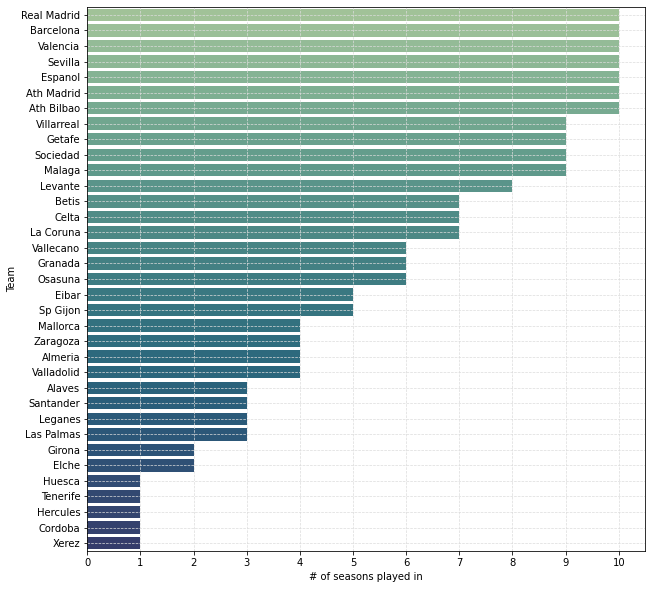

In [ ]:
plt.figure(figsize=(10,10));
sns.barplot(x='Season', 
            y='HomeTeam',
            palette='crest',
            data=dfSeason.sort_values(by='Season', ascending=False));
x = np.arange(0, 11)
plt.ylabel('Team');
plt.xlabel('# of seasons played in');
plt.grid(color='gainsboro', linestyle='--', linewidth=0.7);
plt.xticks(ticks=x);

As shown in the following figure, seven teams have made an appearance in every season - *Real Madrid, Barcelona, Valencia, Sevilla, Español, Athletico Mardric*, and *Athletico Bilbao*. 

Five teams - *Huesca*, *Tenerife*, *Hercules*, *Cordoba* and *Xerez* - have made an appearance only once. Since, the question i want to answer is that of consistancy, these 5 one-hit wonders will be in the focus during the analysis. 

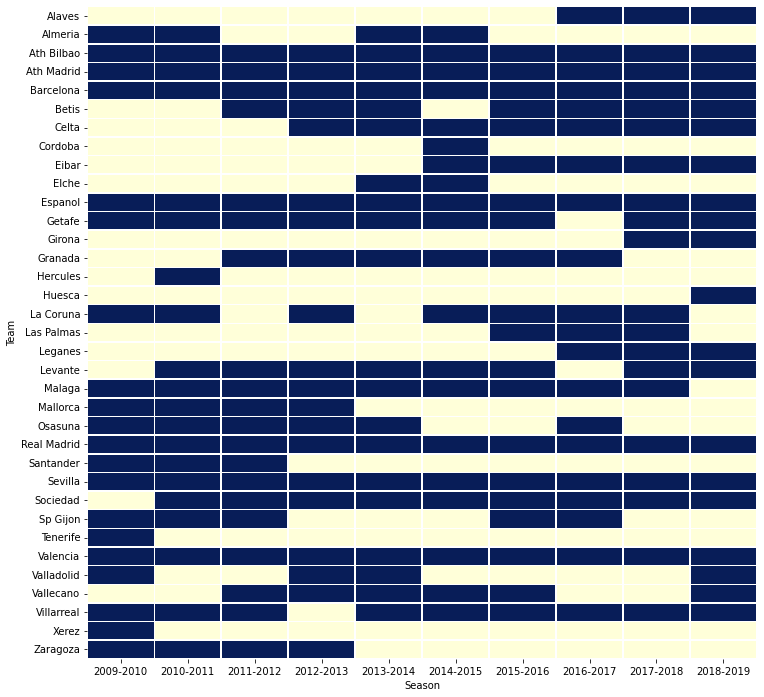

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(pd.crosstab(df.HomeTeam, df.Season), linewidths=.5, cmap="YlGnBu", cbar=False);
plt.ylabel('Team');

In [ ]:
cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
df2 = df[cols].copy()
df2[['SH', 'SA']] = df2.apply(lambda x: [3, 0] if x['FTHG'] > x['FTAG'] else [1, 1] if x['FTHG'] == x['FTAG'] else [0,3], axis=1, result_type='expand')
df2.Date=df2.Date.astype(np.datetime64)

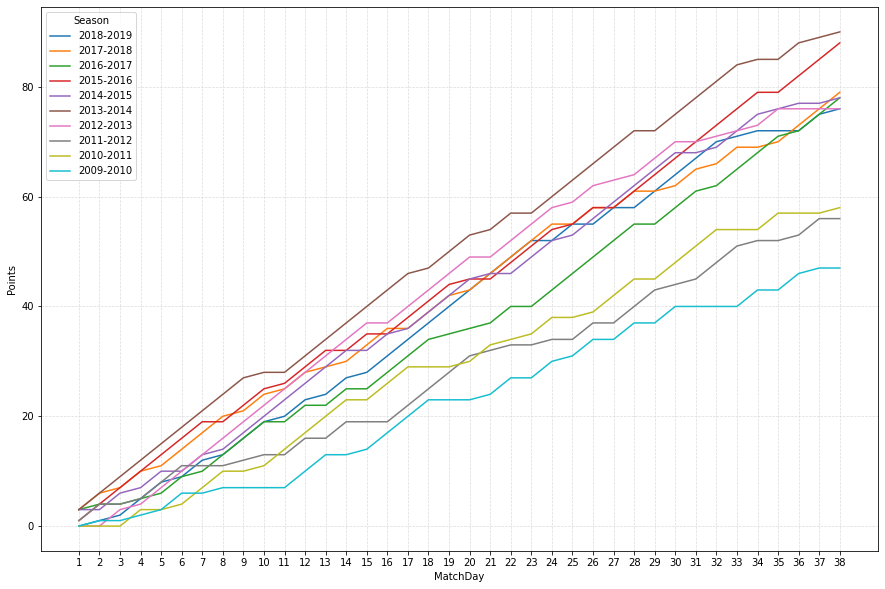

In [ ]:
team = 'Ath Madrid'

#Compute back-to-back seasons
seasons = df2[df2.HomeTeam==team].Season.unique();
backToBack = []
for i, val in enumerate(seasons[:-1]):
  s1 = str.split(seasons[i],'-')
  s2 = str.split(seasons[i+1], '-')
  if s1[0]==s2[1]:
    #print(i, val, seasons[i], seasons[i+1])
    backToBack.insert(0,  [seasons[i], seasons[i+1]])

#compute point for the team in all the seasons
points = None
for season in df2.Season.unique():
  sH = df2[(df2.Season == season) & (df2.HomeTeam==team)].copy()
  sH['Points']=sH.SH
  sA = df2[(df2.Season == season) & (df2.AwayTeam==team)].copy()
  sA['Points']=sA.SA
  s = pd.merge(sH, sA, how='outer').sort_values(by='Date', ascending=True).reset_index(drop=True).reset_index()
  s.Points = s.Points.cumsum()
  s['MatchDay']=s['index']+1
  s.drop(['index'], axis=1, inplace=True)
  if points is None:
    points = s.copy()
  else:
    points = points.append(s, ignore_index=True)

#points[['Season', 'Date', 'Points', 'index']]
x = np.arange(1, 39)
plt.figure(figsize=(15,10));
sns.lineplot(y=points.Points, x=points.MatchDay, hue=points.Season);
plt.grid(color='gainsboro', linestyle='--', linewidth=0.7);
plt.xticks(ticks=x);

In [ ]:
backToBack

[['2010-2011', '2009-2010'],
 ['2011-2012', '2010-2011'],
 ['2012-2013', '2011-2012'],
 ['2013-2014', '2012-2013'],
 ['2014-2015', '2013-2014'],
 ['2015-2016', '2014-2015'],
 ['2016-2017', '2015-2016'],
 ['2017-2018', '2016-2017'],
 ['2018-2019', '2017-2018']]

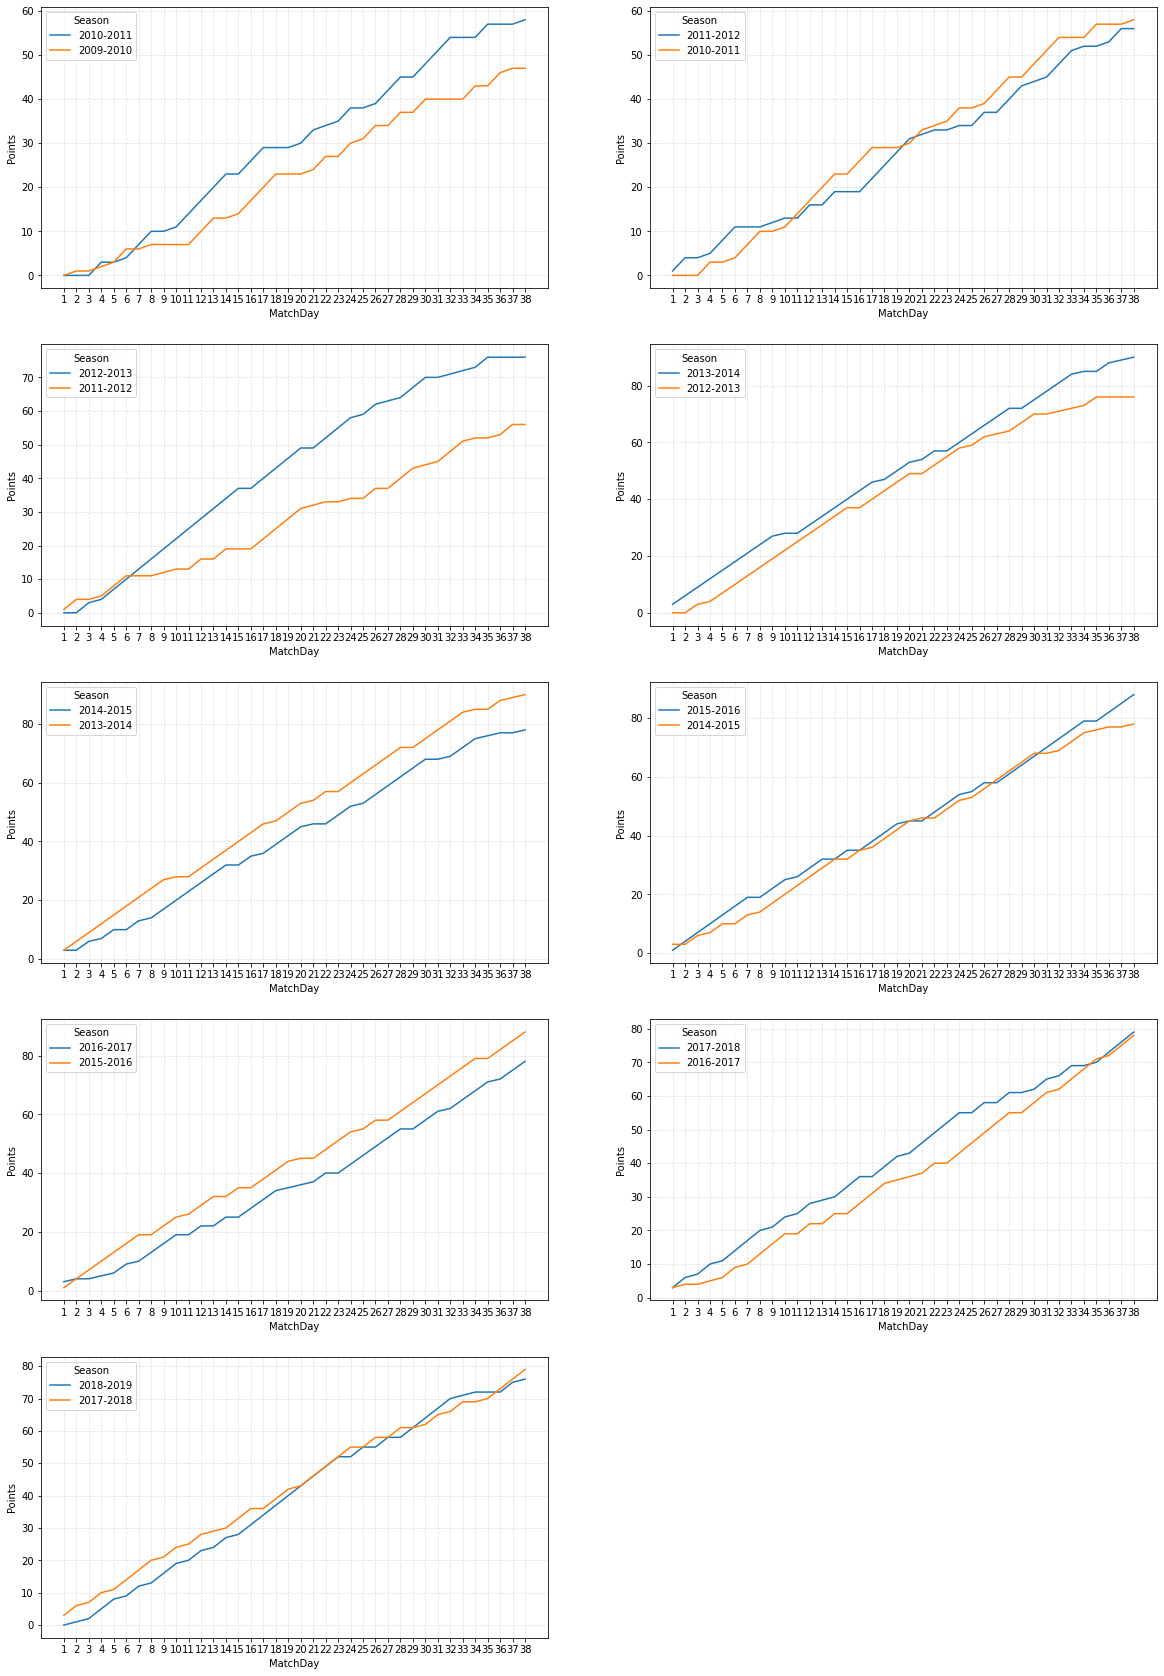

In [ ]:
#plot consequtive performances
r=len(backToBack)
c = int(r/2)+1
plt.figure(figsize=(20,30));
for i, v in enumerate(backToBack,1):
  plt.subplot(c,2,i)
  pairPoints = points[(points.Season == v[0]) | (points.Season == v[1])]
  sns.lineplot(y=pairPoints.Points, x=pairPoints.MatchDay, hue=pairPoints.Season);
  plt.grid(color='gainsboro', linestyle='--', linewidth=0.7);
  plt.xticks(ticks=x);